In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import scipy.signal as signal

from pathlib import Path
import glob
import shutil
import os
import pickle

import sys
sys.path.append('/storage3/eva/code/remapping/src')
import path_formatting as pf
import oe
import utils

In [3]:
date = "20250915"
animal = "eb03"
sr = 30000

dat_path, ks_path, csv_path, res_path = utils.path_load(date, animal,p=True)
os.makedirs(res_path, exist_ok=True)

Ola! For folders inside of res_path: Path(res_path)/"folder_name"
To make new folder (if not exist): your_path.mkdir(parents=True, exist_ok=True)


In [4]:
goodspiketimes = oe.ks_load(ks_path)
res_path_path = Path(res_path)
with open(Path(res_path) / f"preprocessing/behav_periods_{animal}_{date}.pkl", "rb") as f:
    periods = pickle.load(f)

Sup! U have...
51 phy-good clusters


## Slow but precise

In [5]:
# Load Kilosort outputs
spike_clusters = np.load(ks_path+"/spike_clusters.npy")  # (N,)
spike_times = np.load(ks_path+"/spike_times.npy")  # (N,)
spike_templates = np.load(ks_path+"/spike_templates.npy")  # (N,)
templates = np.load(ks_path+"/templates.npy")  # (num_templates, num_timepoints, num_channels)

In [6]:
uoi = list(goodspiketimes.keys())
print(uoi)

[60, 89, 131, 190, 642, 647, 661, 663, 669, 673, 675, 677, 681, 683, 685, 687, 689, 699, 703, 711, 712, 716, 720, 722, 724, 734, 746, 750, 752, 754, 760, 762, 764, 770, 775, 777, 779, 781, 795, 805, 809, 811, 813, 815, 817, 819, 821, 823, 829, 834, 835]


In [7]:
# here we searching for 3 best channels for each unit based on ptp (peak to peak - amplitude)

units_channels = np.zeros((len(uoi), 4), dtype=int)

for i, unit_id in enumerate(uoi):
    units_channels[i, 0] = unit_id

    # Find the template used by the unit
    unit_template_ids = spike_templates[spike_clusters == unit_id]
    main_template_id = np.bincount(unit_template_ids).argmax()
    template = templates[main_template_id]

    # Get peak-to-peak amplitudes for all channels
    ptp_amplitudes = np.ptp(template, axis=0)

    # Get indices of top 3 channels
    top3_channels = np.argsort(ptp_amplitudes)[-3:][::-1]  # descending order

    # Store top 3 channels
    units_channels[i, 1:4] = top3_channels

In [8]:
units_channels  # [unit_id, best_channel, second_best, third_best]

array([[ 60, 185, 186, 184],
       [ 89, 180, 181, 182],
       [131, 368, 367, 369],
       [190, 167, 166, 165],
       [642, 266, 265, 267],
       [647, 171, 172, 170],
       [661, 266, 265, 267],
       [663, 160, 161, 162],
       [669, 281, 280, 282],
       [673, 267, 266, 268],
       [675, 353, 354, 352],
       [677,  93,  94,  92],
       [681,  63,  64,  62],
       [683, 168, 169, 167],
       [685, 179, 178, 180],
       [687, 280, 279, 281],
       [689, 327, 328, 326],
       [699,  82,  83,  81],
       [703, 189, 188, 186],
       [711, 189, 188, 186],
       [712, 189, 188, 186],
       [716, 189, 188, 186],
       [720, 167, 168, 166],
       [722, 323, 324, 322],
       [724, 163, 164, 162],
       [734, 383, 382, 381],
       [746, 186, 185, 187],
       [750, 187, 188, 186],
       [752, 121, 122, 120],
       [754,  86,  87,  85],
       [760, 171, 172, 170],
       [762, 179, 178, 180],
       [764,  74,  75,  76],
       [770, 186, 185, 187],
       [775, 1

In [9]:
# algorythm that searches for the best channels set 
# minimazing the total number of channels to be processed
from collections import Counter

# Assume: units_channels is of shape (n_units, 4): [unit_id, ch1, ch2, ch3]
n_units = units_channels.shape[0]
assigned_channels = np.full(n_units, -1, dtype=int)  # -1 = unassigned

remaining_indices = set(range(n_units))

while remaining_indices:
    # Count how often each channel appears among unassigned units
    channel_counter = Counter()
    for i in remaining_indices:
        top3 = units_channels[i, 1:]
        channel_counter.update(top3)

    # Choose channel that covers most unassigned units
    best_channel = channel_counter.most_common(1)[0][0]

    # Assign it to every unassigned unit where it's in the top 3
    for i in list(remaining_indices):
        if best_channel in units_channels[i, 1:]:
            assigned_channels[i] = best_channel
            remaining_indices.remove(i)

# Result: each index in assigned_channels corresponds to the chosen channel for that unit
assigned_channels = np.column_stack([units_channels[:, 0], assigned_channels])

In [10]:
assigned_channels # [unit_id, selected_channel]

array([[ 60, 186],
       [ 89, 181],
       [131, 368],
       [190, 167],
       [642, 266],
       [647, 170],
       [661, 266],
       [663, 162],
       [669, 281],
       [673, 266],
       [675, 353],
       [677,  93],
       [681,  63],
       [683, 167],
       [685, 179],
       [687, 281],
       [689, 328],
       [699,  82],
       [703, 186],
       [711, 186],
       [712, 186],
       [716, 186],
       [720, 167],
       [722, 323],
       [724, 162],
       [734, 383],
       [746, 186],
       [750, 186],
       [752, 120],
       [754,  86],
       [760, 170],
       [762, 179],
       [764,  74],
       [770, 186],
       [775, 181],
       [777, 186],
       [779, 186],
       [781, 179],
       [795, 271],
       [805, 331],
       [809, 170],
       [811, 328],
       [813, 167],
       [815, 120],
       [817, 124],
       [819, 120],
       [821, 220],
       [823, 120],
       [829, 176],
       [834, 179],
       [835, 271]])

In [11]:
len(np.unique(assigned_channels[:,1])) # nb of channels to be processed (out of 384)

24

In [12]:
from collections import defaultdict

# 1. Group units by their assigned best channel
channel_to_units = defaultdict(list)
unit_id_to_index = {unit_id: i for i, unit_id in enumerate(uoi)}  # in case uoi is not in order

for unit_id, ch in assigned_channels:
    channel_to_units[ch].append(unit_id)

# 2. Set parameters
window_size_l, window_size_r = 30, 60
window_size = 41 # for median filter
gain = 0.195 # Neuropixels probe gain
wf_all = {}
mean_wf_all = {}

# 3. Process per channel
for ch, unit_ids in channel_to_units.items():
    print(f"Processing channel {ch} for {len(unit_ids)} units...")

    # Load and filter the channel only once
    raw_ch, idx = oe.load_binary(
        dat_path,
        channels=[ch],
        n_channels=385,
        method=4,
        intype='int16',
        outtype='float32',
        resample=1,
        return_orig_index=True
    )
    raw_ch = raw_ch[0, :]
    baseline = signal.medfilt(raw_ch, kernel_size=window_size)
    filtered_ch = raw_ch - baseline

    # 4. For each unit assigned to this channel
    for unit_id in unit_ids:
        spike_mask = spike_clusters == unit_id
        spike_times_unit = spike_times[spike_mask][:1000]

        # Remove spikes near the edge
        valid_mask = (spike_times_unit > window_size_l) & (spike_times_unit < len(filtered_ch) - window_size_r)
        valid_spike_times = spike_times_unit[valid_mask]

        if len(valid_spike_times) == 0:
            continue

        # Vectorized waveform extraction
        idxs = np.arange(-window_size_l, window_size_r + 1)
        all_idxs = valid_spike_times[:, None] + idxs[None, :]
        waveforms = filtered_ch[all_idxs] * gain
        mean_wf = np.mean(waveforms, axis=0)

        wf_all[unit_id] = waveforms
        mean_wf_all[unit_id] = mean_wf

# Save

with open(Path(res_path) /"wf_all_expanded.pkl", "wb") as f:
    pickle.dump(wf_all, f)

with open(Path(res_path) /"mean_wf_all_expanded.pkl", "wb") as f:
    pickle.dump(mean_wf_all, f)

Processing channel 186 for 10 units...
Processing channel 181 for 2 units...
Processing channel 368 for 1 units...
Processing channel 167 for 4 units...
Processing channel 266 for 3 units...
Processing channel 170 for 3 units...
Processing channel 162 for 2 units...


FileNotFoundError: File /storage3/eva/data/raw/oe/eb03/eb03_20250915/continuous.dat not found.

In [ ]:
# # Load
# with open(res_path + "/wf_all_expanded.pkl", "rb") as f:
#     wf_all = pickle.load(f)

# with open(res_path + "/mean_wf_all_expanded.pkl", "rb") as f:
#     mean_wf_all = pickle.load(f)

In [13]:
wf_path = os.path.join(res_path, 'wf_full')
os.makedirs(wf_path, exist_ok=True)

In [14]:
def plot_waveforms(unit_id, wf_all, mean_wf_all, window_size_l=30, sampling_rate=30000, color='C0', save=True):
    if unit_id not in wf_all or unit_id not in mean_wf_all:
        print(f"Unit {unit_id} not found in waveform data.")
        return

    waveforms = wf_all[unit_id]
    mean_wf = mean_wf_all[unit_id]

    # Create time axis in ms
    n_samples = waveforms.shape[1]
    t = (np.arange(n_samples) - window_size_l) / sampling_rate * 1000  # in ms

    plt.figure(figsize=(3, 3))
    # Plot all individual waveforms
    plt.plot(t, waveforms.T, color='lightgray', linewidth=0.5, alpha=0.5)
    # Plot mean waveform
    plt.plot(t, mean_wf, color=color, linewidth=2)
    plt.xlabel("Time (ms)")
    plt.ylabel("Amplitude (µV)")

    filename = f"unit_{unit_id}_wf_full_{date}"

    plt.title(filename)
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(os.path.join(wf_path, filename), dpi=300, bbox_inches='tight')

    if unit_id == list(goodspiketimes.keys())[0]:
        plt.show()
    plt.close()

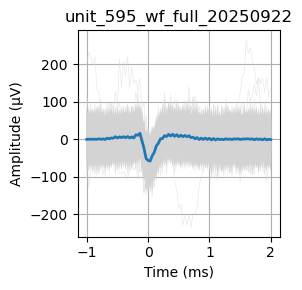

In [15]:
for unit in uoi:
    plot_waveforms(unit_id=unit, wf_all=wf_all, mean_wf_all=mean_wf_all)

## Fast

best period

In [6]:
# Step 1: Count spikes per period per cell
spike_counts = {}

for cell_id, spikes in goodspiketimes.items():
    counts = {}
    for period_name, (start, end) in periods.items():
        n_spikes = np.sum((spikes >= start) & (spikes <= end))
        counts[period_name] = n_spikes
    spike_counts[cell_id] = counts

# Step 2: For each cell, find the period with the most spikes
cell_best_periods = []
for counts in spike_counts.values():
    max_spikes = max(counts.values())
    best_periods = [period for period, count in counts.items() if count == max_spikes]
    cell_best_periods.append(best_periods)  # list of bests in case of tie

# Step 3: Count how many cells favor each period
from collections import Counter

# Flatten and count all mentions of "best" periods
period_votes = Counter()
for bests in cell_best_periods:
    for period in bests:
        period_votes[period] += 1 / len(bests)  # equally divide if multiple bests

# Step 4: In case of tie, choose shorter one
max_vote = max(period_votes.values())
candidates = [p for p, v in period_votes.items() if v == max_vote]

if len(candidates) == 1:
    final_period = candidates[0]
else:
    durations = {p: periods[p][1] - periods[p][0] for p in candidates}
    final_period = min(durations, key=durations.get)  # shorter wins

print(f"Best period: {final_period}")

Best period: sl3


In [7]:
qualified_periods = []

for period_name, (start, end) in periods.items():
    all_above_1000 = True
    for cell_id, spikes in goodspiketimes.items():
        n_spikes = np.sum((spikes >= start) & (spikes <= end))
        if n_spikes < 1000:
            all_above_1000 = False
            break
    if all_above_1000:
        qualified_periods.append(period_name)

if qualified_periods:
    print("Periods where all cells have ≥ 1000 spikes:")
    print(qualified_periods)
else:
    print("No period has ≥ 1000 spikes for all cells.")

No period has ≥ 1000 spikes for all cells.


In [8]:
# Step 1: Count total spikes per cell
total_spikes_per_cell = {cell_id: len(spikes) for cell_id, spikes in goodspiketimes.items()}

# Step 2: Find the cell with the fewest total spikes
min_cell = min(total_spikes_per_cell, key=total_spikes_per_cell.get)

# Step 3: Count its spikes per period
spikes = goodspiketimes[min_cell]
spikes_per_period = {
    period_name: np.sum((spikes >= start) & (spikes <= end))
    for period_name, (start, end) in periods.items()
}

# Step 4: Get the max count across periods
max_spikes_in_period = max(spikes_per_period.values())

print(f"Cell with fewest total spikes: {min_cell} ({total_spikes_per_cell[min_cell]} spikes total)")
print(f"Maximum in any period: {max_spikes_in_period}")

Cell with fewest total spikes: 205 (129 spikes total)
Maximum in any period: 62


In [23]:
raw_ch, idx = oe.load_binary(
    dat_path,
    channels=[384],
    n_channels=385,
    method=4,
    intype='int16',
    outtype='float32',
    resample=1,
    return_orig_index=True
)

In [26]:
ttl = raw_ch[0,:]
ttl.shape

(125128831,)

In [30]:
rising_edges = np.where((ttl[:-1] == 0) & (ttl[1:] == 1))[0] + 1
rising_edges

array([   236162, 124915410])

In [31]:
final_period

'sl3'

In [44]:
units_channels = np.zeros((len(uoi), 4), dtype=int)

for i, unit_id in enumerate(uoi):
    units_channels[i, 0] = unit_id

    # Find the template used by the unit
    unit_template_ids = spike_templates[spike_clusters == unit_id]
    main_template_id = np.bincount(unit_template_ids).argmax()
    template = templates[main_template_id]

    # Get peak-to-peak amplitudes for all channels
    ptp_amplitudes = np.ptp(template, axis=0)

    # Get indices of top 3 channels
    top3_channels = np.argsort(ptp_amplitudes)[-3:][::-1]  # descending order

    # Store top 3 channels
    units_channels[i, 1:4] = top3_channels

In [45]:
from collections import Counter

# Assume: units_channels is of shape (n_units, 4): [unit_id, ch1, ch2, ch3]
n_units = units_channels.shape[0]
assigned_channels = np.full(n_units, -1, dtype=int)  # -1 = unassigned

remaining_indices = set(range(n_units))

while remaining_indices:
    # Count how often each channel appears among unassigned units
    channel_counter = Counter()
    for i in remaining_indices:
        top3 = units_channels[i, 1:]
        channel_counter.update(top3)

    # Choose channel that covers most unassigned units
    best_channel = channel_counter.most_common(1)[0][0]

    # Assign it to every unassigned unit where it's in the top 3
    for i in list(remaining_indices):
        if best_channel in units_channels[i, 1:]:
            assigned_channels[i] = best_channel
            remaining_indices.remove(i)

# Result: each index in assigned_channels corresponds to the chosen channel for that unit
# You can make a new array like:
units_best_channel_minimized = np.column_stack([units_channels[:, 0], assigned_channels])

In [46]:
units_best_channel_minimized

array([[  5, 287],
       [  8, 382],
       [ 12, 188],
       [ 15, 287],
       [ 25, 282],
       [ 33, 183],
       [ 34, 183],
       [ 35, 183],
       [ 36, 183],
       [ 46, 183],
       [ 49, 183],
       [ 50, 183],
       [ 58,  85],
       [ 60, 183],
       [ 62, 181],
       [ 63, 275],
       [ 69,  82],
       [ 70,  82],
       [ 71,  82],
       [ 73,  82],
       [ 74,  82],
       [ 79, 178],
       [ 81, 275],
       [ 83, 275],
       [ 85,  82],
       [ 94, 271],
       [104, 174],
       [108, 271],
       [116, 170],
       [128, 170],
       [129, 170],
       [130, 170],
       [140, 264],
       [146,  69],
       [152, 167],
       [153, 167],
       [161,  69],
       [175,  66],
       [177, 162],
       [178, 162],
       [179, 162],
       [188, 160],
       [189, 162],
       [191, 160],
       [201,  62],
       [202,  62],
       [205, 160],
       [213,  62],
       [220, 253],
       [221, 253],
       [231, 153],
       [240, 153],
       [241,

In [49]:
from collections import defaultdict
from scipy.ndimage import median_filter
import numpy as np

# 1. Group units by their best channel
channel_to_units = defaultdict(list)
unit_id_to_index = {unit_id: i for i, unit_id in enumerate(uoi)}

for unit_id, ch in units_best_channel_minimized:
    channel_to_units[ch].append(unit_id)

# 2. Parameters
window_size_l, window_size_r = 30, 60
window_size = 41  # for median filter
gain = 0.195  # Neuropixels gain
max_spikes_per_unit = 1000

# Precompute waveform offsets
idxs = np.arange(-window_size_l, window_size_r + 1)

wf_all = {}
mean_wf_all = {}

# 3. Process each channel
for ch, unit_ids in channel_to_units.items():
    print(f"Processing channel {ch} with {len(unit_ids)} units...")

    try:
        raw_ch, idx = oe.load_binary(
            dat_path,
            channels=[ch],
            n_channels=385,
            method=4,
            intype='int16',
            outtype='float32',
            resample=1,
            return_orig_index=True
        )
    except Exception as e:
        print(f"Error loading channel {ch}: {e}")
        continue

    raw_ch = raw_ch[0, :]
    if len(raw_ch) < (window_size_l + window_size_r + 1):
        print(f"Channel {ch} too short for waveform extraction.")
        continue

    # Median filter and subtract baseline
    baseline = median_filter(raw_ch, size=window_size)
    filtered_ch = raw_ch - baseline

    for unit_id in unit_ids:
        # spike_mask = spike_clusters == unit_id
        # spike_times_unit = spike_times[spike_mask]
        spike_times_unit = goodspiketimes_period[unit_id]

        if len(spike_times_unit) == 0:
            continue  # skip if unit has no spikes at all

        # Only keep spikes not too close to the edges
        valid_mask = (spike_times_unit > window_size_l) & \
                     (spike_times_unit < len(filtered_ch) - window_size_r)
        valid_spike_times = spike_times_unit[valid_mask]

        if len(valid_spike_times) == 0:
            continue  # skip units with spikes only near edges

        # Limit to max_spikes_per_unit but keep all available spikes
        valid_spike_times = valid_spike_times[:max_spikes_per_unit]

        try:
            all_idxs = valid_spike_times[:, None] + idxs[None, :]
            waveforms = filtered_ch[all_idxs] * gain
        except Exception as e:
            print(f"Waveform extraction failed for unit {unit_id}: {e}")
            continue

        mean_wf = np.mean(waveforms, axis=0)
        wf_all[unit_id] = waveforms
        mean_wf_all[unit_id] = mean_wf

Processing channel 287 with 2 units...
Processing channel 382 with 1 units...
Processing channel 188 with 1 units...
Processing channel 282 with 1 units...
Processing channel 183 with 8 units...
Processing channel 85 with 1 units...
Processing channel 181 with 1 units...
Processing channel 275 with 3 units...
Processing channel 82 with 6 units...
Processing channel 178 with 1 units...
Processing channel 271 with 2 units...
Processing channel 174 with 1 units...
Processing channel 170 with 4 units...
Processing channel 264 with 1 units...
Processing channel 69 with 2 units...
Processing channel 167 with 2 units...
Processing channel 66 with 1 units...
Processing channel 162 with 4 units...
Processing channel 160 with 3 units...
Processing channel 62 with 3 units...
Processing channel 253 with 2 units...
Processing channel 153 with 3 units...
Processing channel 344 with 1 units...
Processing channel 55 with 1 units...
Processing channel 151 with 1 units...
Processing channel 52 with 2 un

for future ask gpt how to implement Parallel processing across channels

In [50]:
# Save
res_path_path = Path(res_path)

with open(res_path_path/"wf_all.pkl", "wb") as f:
    pickle.dump(wf_all, f)

with open(res_path_path/"mean_wf_all.pkl", "wb") as f:
    pickle.dump(mean_wf_all, f)

So..

In [58]:
wf_nitro_path = os.path.join(res_path, 'wf_nitro')
os.makedirs(wf_nitro_path, exist_ok=True)

In [63]:
def plot_waveforms(unit_id, wf_all, mean_wf_all, window_size_l=30, sampling_rate=30000, color='C0', save=True):
    if unit_id not in wf_all or unit_id not in mean_wf_all:
        print(f"Unit {unit_id} not found in waveform data.")
        return

    waveforms = wf_all[unit_id]
    mean_wf = mean_wf_all[unit_id]

    # Create time axis in ms
    n_samples = waveforms.shape[1]
    t = (np.arange(n_samples) - window_size_l) / sampling_rate * 1000  # in ms

    plt.figure(figsize=(3, 3))
    plt.plot(t, waveforms.T, color='lightgray', linewidth=0.5, alpha=0.5)
    plt.plot(t, mean_wf, color=color, linewidth=2)
    plt.xlabel("Time (ms)")
    plt.ylabel("Amplitude (µV)")

    filename = f"unit_{unit_id}_wf_{date}"

    plt.title(filename)
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(os.path.join(wf_nitro_path, filename), dpi=300, bbox_inches='tight')

    plt.show()


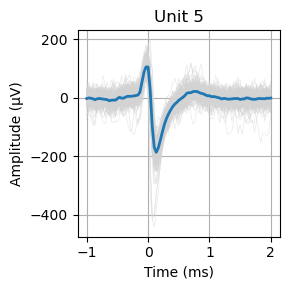

In [62]:
unit=5
plot_waveforms(unit_id=unit, wf_all=wf_all, mean_wf_all=mean_wf_all)

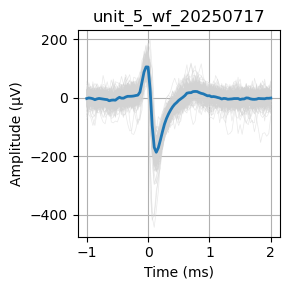

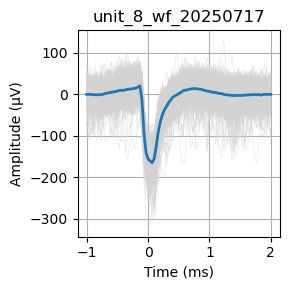

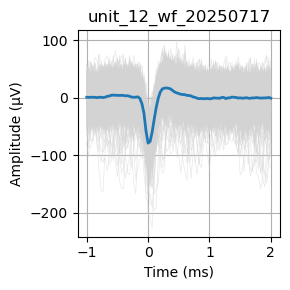

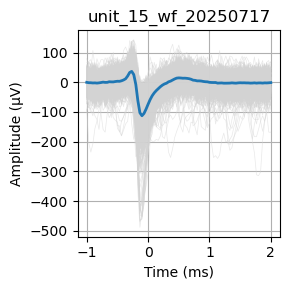

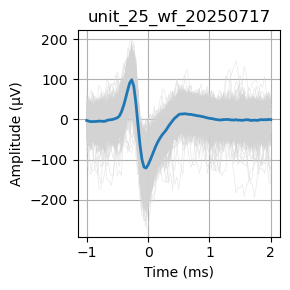

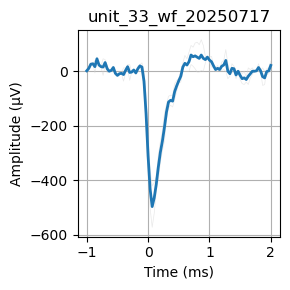

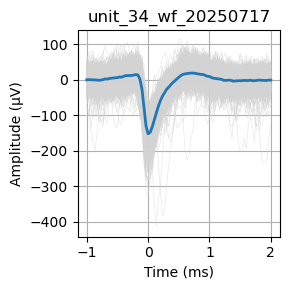

Unit 35 not found in waveform data.


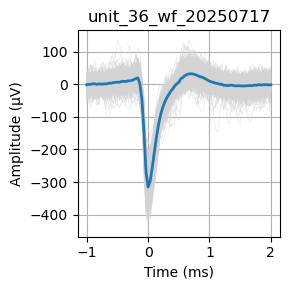

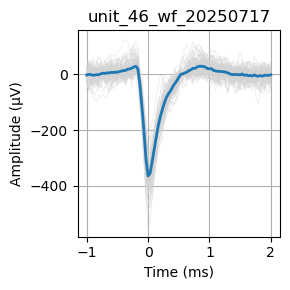

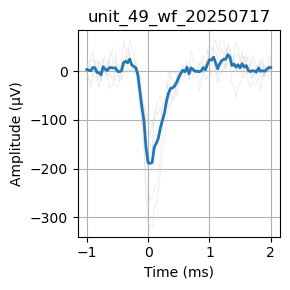

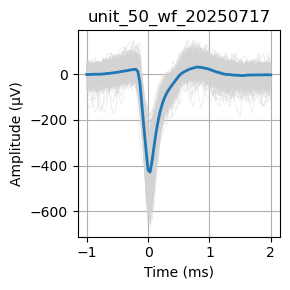

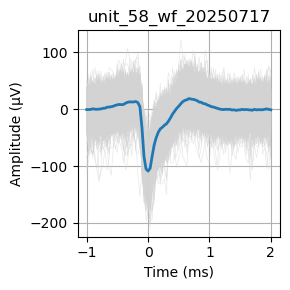

Unit 60 not found in waveform data.


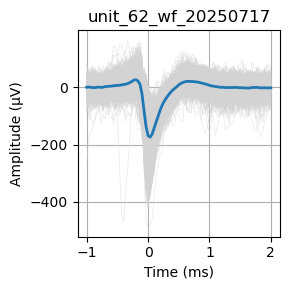

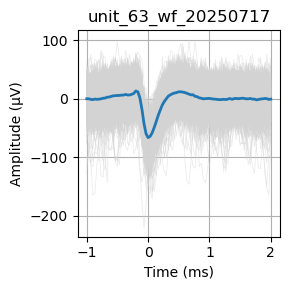

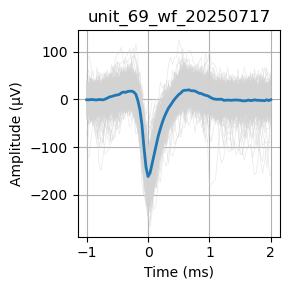

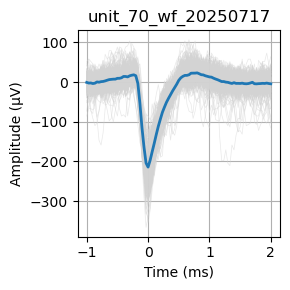

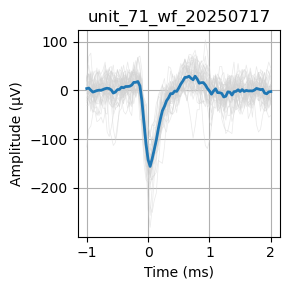

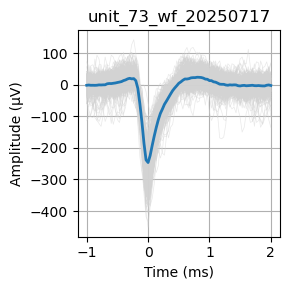

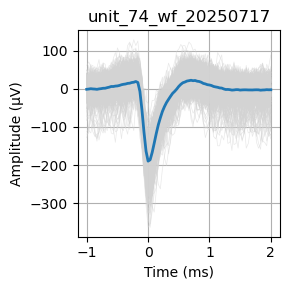

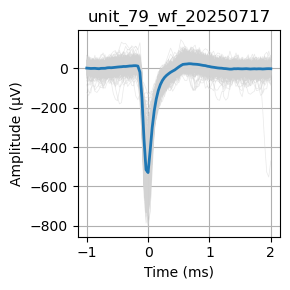

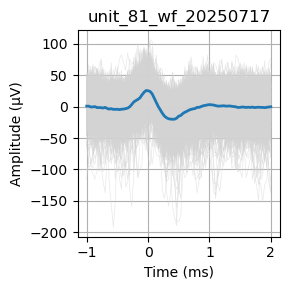

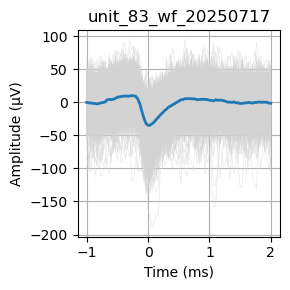

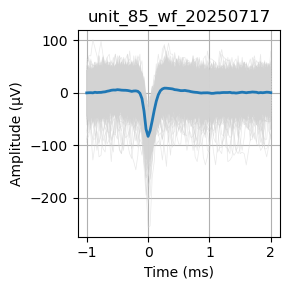

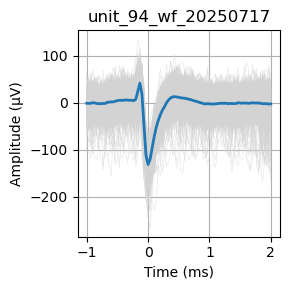

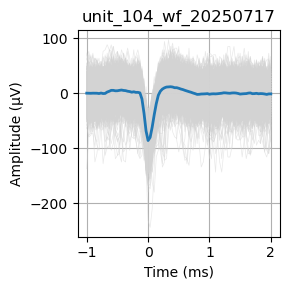

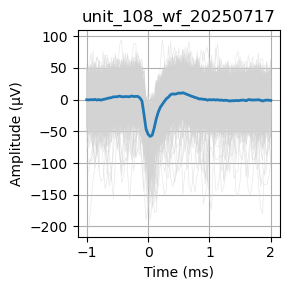

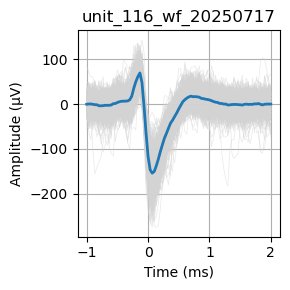

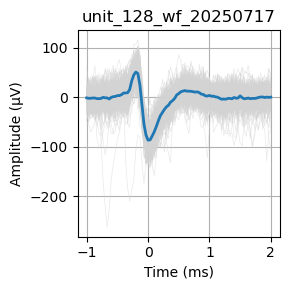

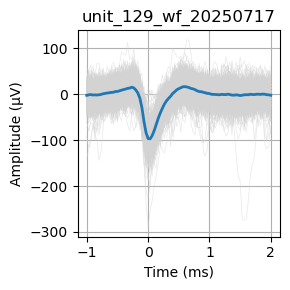

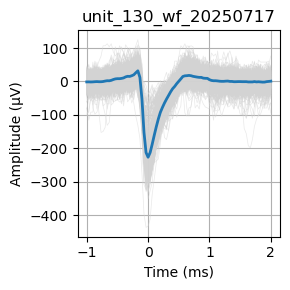

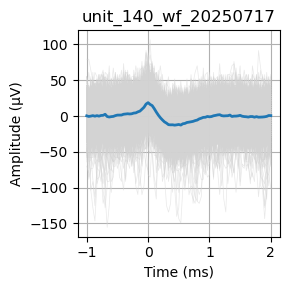

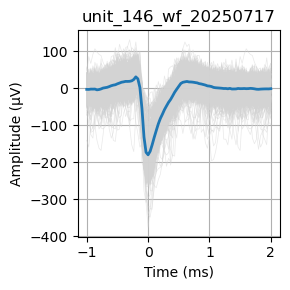

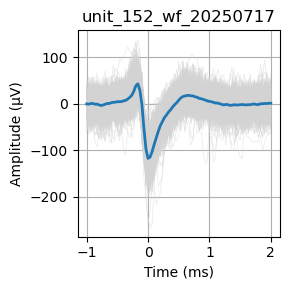

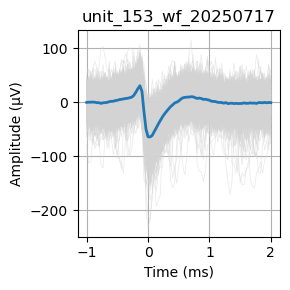

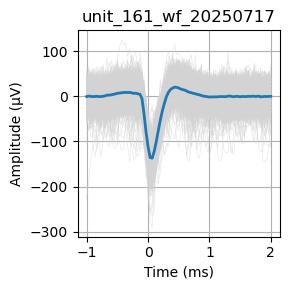

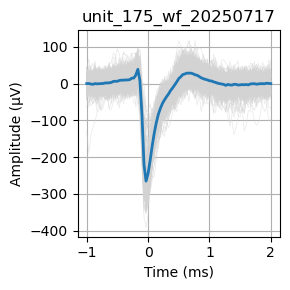

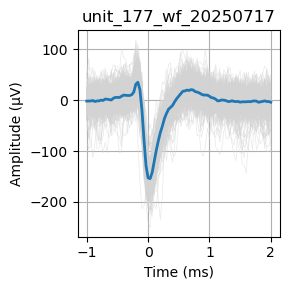

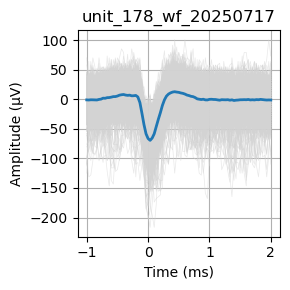

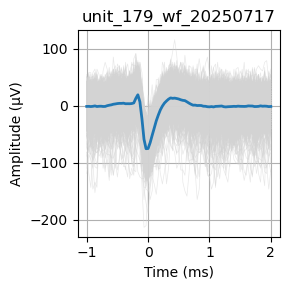

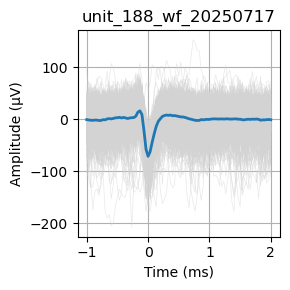

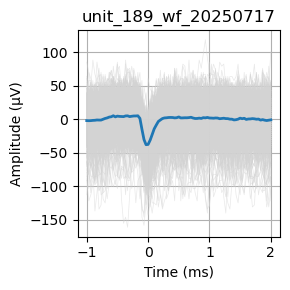

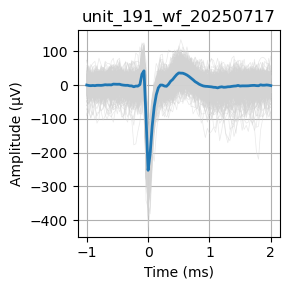

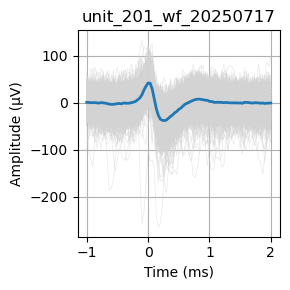

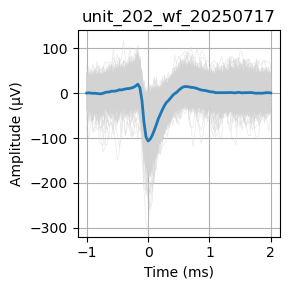

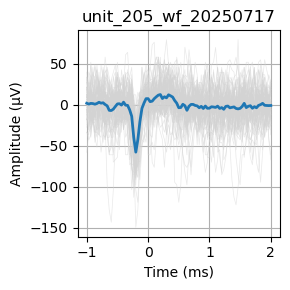

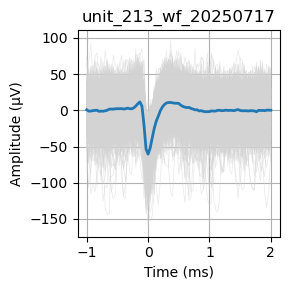

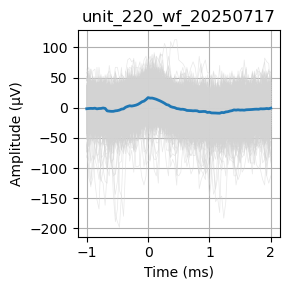

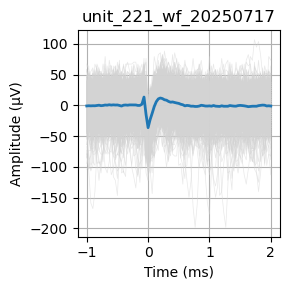

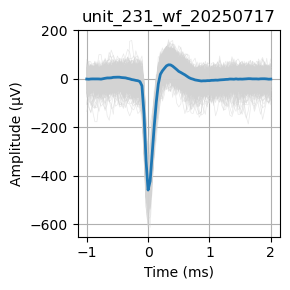

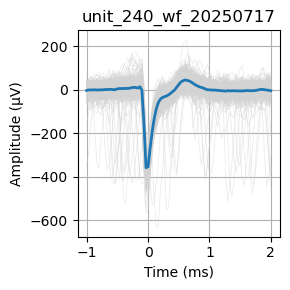

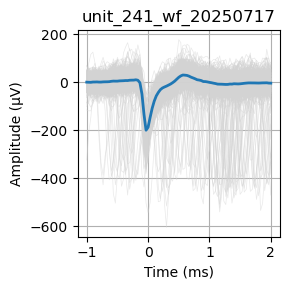

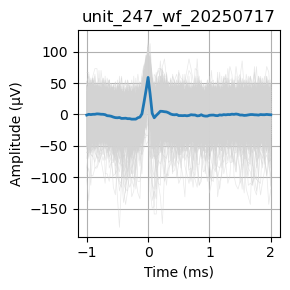

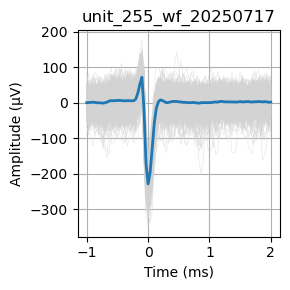

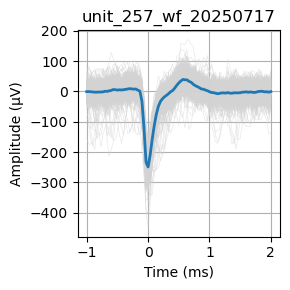

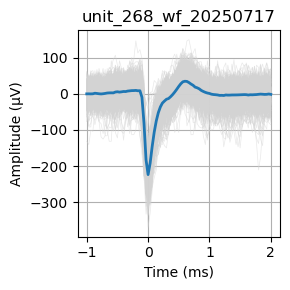

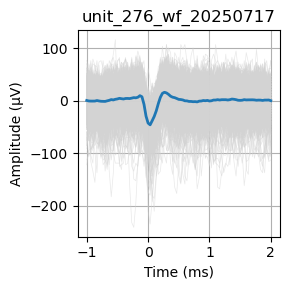

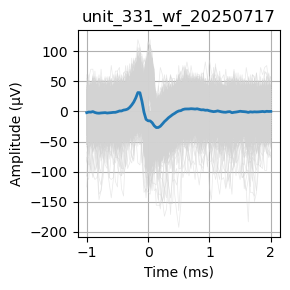

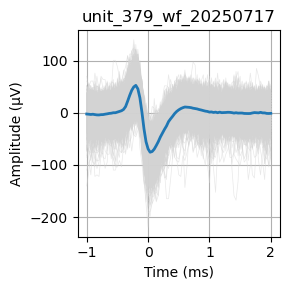

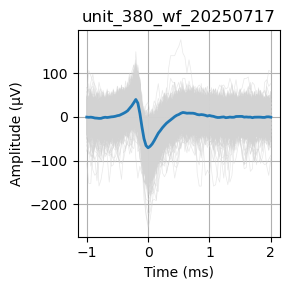

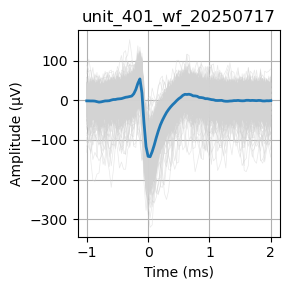

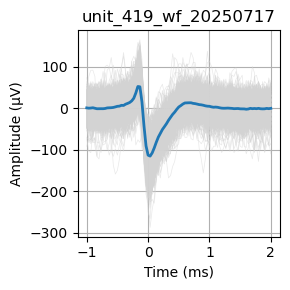

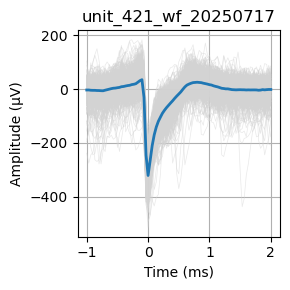

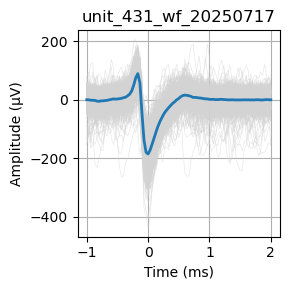

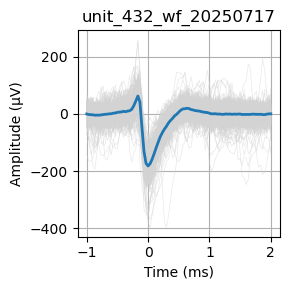

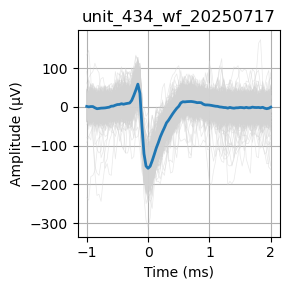

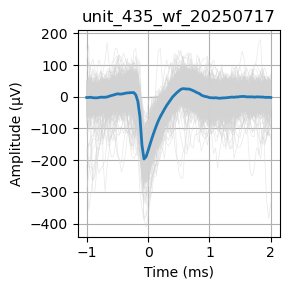

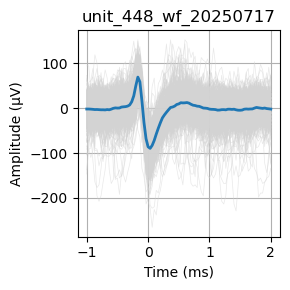

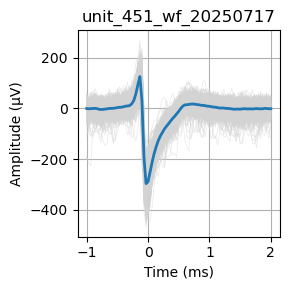

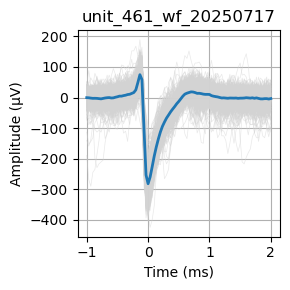

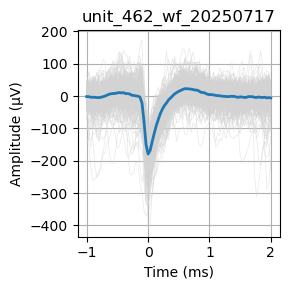

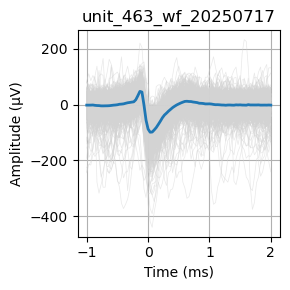

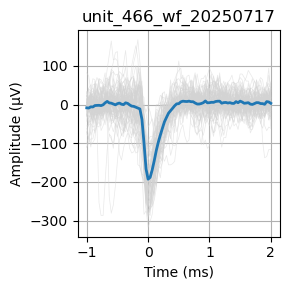

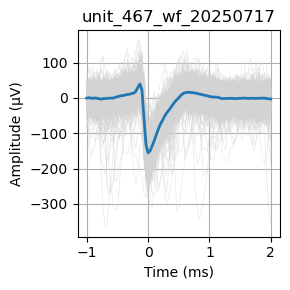

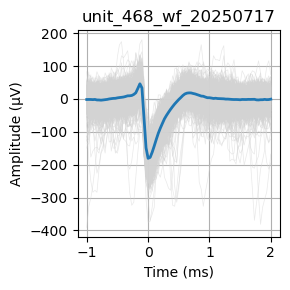

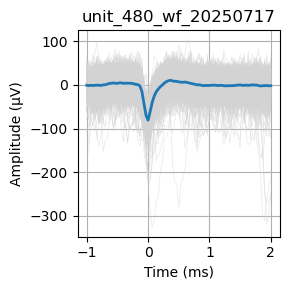

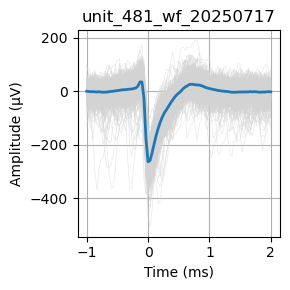

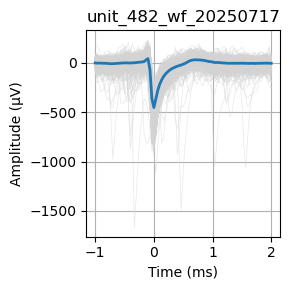

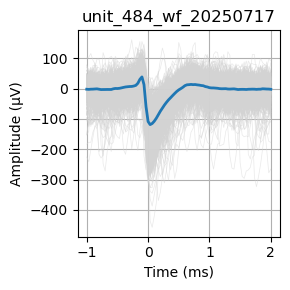

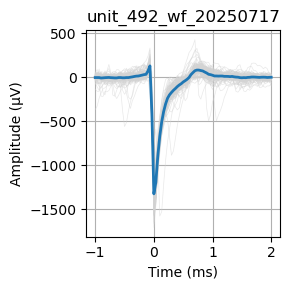

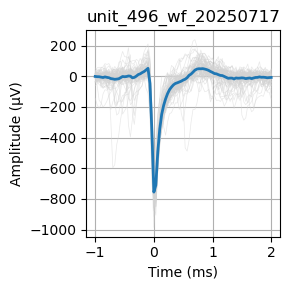

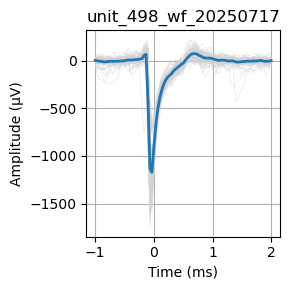

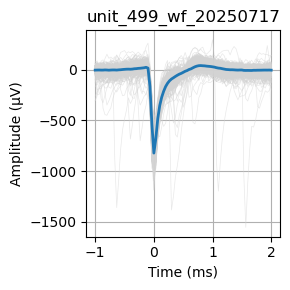

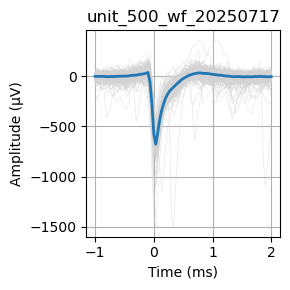

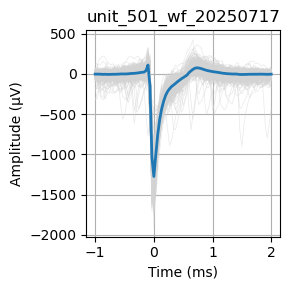

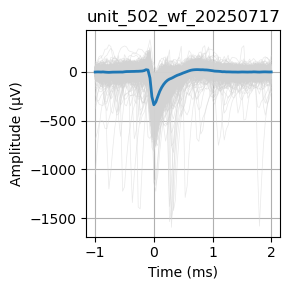

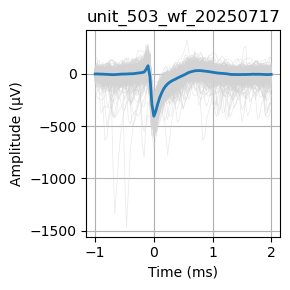

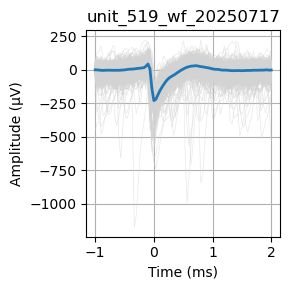

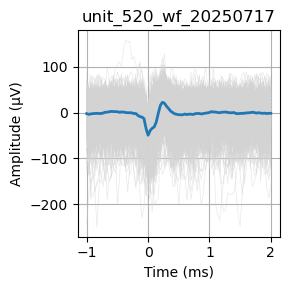

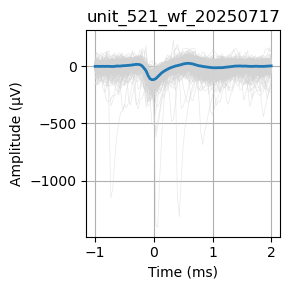

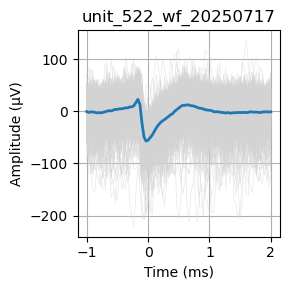

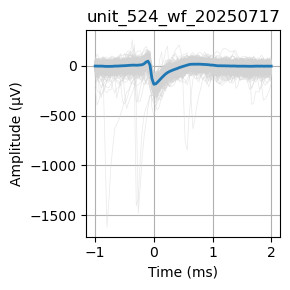

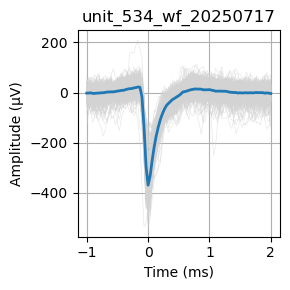

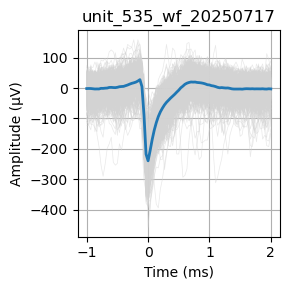

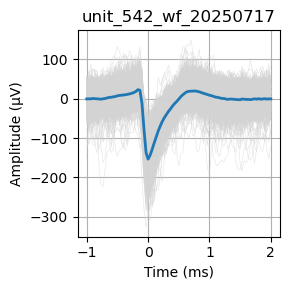

Unit 555 not found in waveform data.


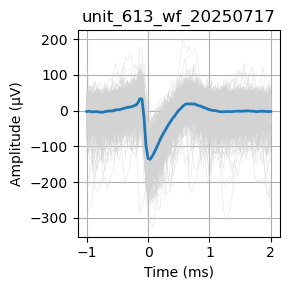

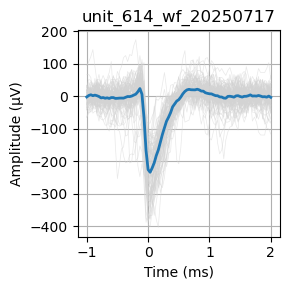

In [64]:
for unit in uoi:
    plot_waveforms(unit_id=unit, wf_all=wf_all, mean_wf_all=mean_wf_all)